In [2]:
# Importing necessary libraries
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi']=80
plt.rcParams['figure.facecolor']='w'
from scipy.optimize import curve_fit
import scipy.stats as sct
from scipy.stats import norm
import math as m
import seaborn as sns
import random as rd
import pandas as pd
from pandas import *

## About

Extracting FD magnitudes (dip sizes) from data of 13 Neutron Monitor (NM) stations of cutoff rigidity < 1GV and plotting them on the y axis with values of the ICME parameter -  $$<\delta B/B>_{MC}$$ (mean turbulent magnetic field inside magnetic cloud)

for 11 ICME events (3 from 2015, 8 from 2014) (number 151 to 141 in Bhattacharjee et al, 2022 (On modelling ICME cross-sections as static MHD columns)) on the x axis, to look for trends and statistical correlations. The definition for calculating dip sizes is explained below, while the $<\delta B/B>_{MC}$ values for all 11 ICME events were taken from Debesh Bhattacharjee's Ph.D. thesis (preprint) at IISER, Pune. 

This ICME parameter $<\delta B/B>_{MC}$  represents the magnitude of the anomalous turbulent fluctuations of magnetic field $B$ inside the magnetic cloud accompanying in ICME and causuing the FD. Theoretically, one would expect that the higher the value of this parameter, the higher the "jiggling" of the cosmic ray particles, the higher magnitude of the dip. Two kinds of data was available for this parameter, depending on the length of the time window over which the $\delta B/B$ values are averaged - tbox = 40mins, tbox = 60 mins. Data has been analyzed and graphs have been plot for both cases separately below. The exact trend from data of 13 NM stations and 11 ICME events can be seen from the graphs below. 

Types of correlation coefficients calculated for the data are - Pearson R, Spearman R, Kendall Tau and slope of best fit line by linear regression. The error in this slope was also calculated. Since this is theoretically expected to be downward linear trend (less cutoff rigidity should correspond to higher FD magnitude), the Pearson R value can be considered the most relevant correlation coefficient. The values of these coefficients obtained can be found before the graphs in this notebook. Spearman R values have been printed on the corresponding graphs.

## Data analyis math - 

1. Time series data obtained from nmdb.eu/nest with 1-hour resolution, for different NM stations, for 11+ ICME events as identified in Debesh's paper, from the WIND catalogue. Window from 96 hours before the shock arrival time to 120 hours after MC end (more time here for scope to analyze recovery times in the future)

2. Trail Smoothed this time series data with a 12 hour window (trail smoothing apparently works better to amplify and showcase local trends in the data (such as the dips we want), compared to central smoothing). 
$$ \text{Smoothed_data}[i] = \text{ mean(11 data points before i} + i^\text{th} \text{data point}) $$

#### Working with counts/sec data - 

3. $$ \text{predip_avg (in counts/s)} = \text{mean(Smoothed_data}[ 0:\text{shock time}]) $$


4. $$ \text{Local minima} = \text{min(Smoothed_data}[\text{shock} : \text{mcend} + 12]) $$. 
      Index of this local minima value is also noted and plotted on the graphs, for a visual aid.


5. $$ \text{FD magnitude (absolute) (in counts/s)} = \text{predip_avg (in counts/s) - local minima (in count/s)} $$


6. $$ \text{FD magnitude (normalized) (dimensionless)} = \left(\frac{\text{Absolute FD magnitude (in counts/s)}}{\text{predip_avg (in counts/s)}}\right)\times 100 $$


#### Working with %deviation - 

7. $$ \% \text{mean deviation}[i] = \left(\frac{\text{Smoothed_data}[i] - \text{predip_avg (in counts/s)}}{\text{predip_avg (in counts/s)}}\right) \times 100 $$


8. $$ \text{Smoothed_percentdev_data}[i] = \text{ mean(11 percentdev data points before i} + i^\text{th} \text{percentdev data point}) $$


9. $$ \text{percentdev_predip_avg (in %)} = \text{mean(Smoothed_percentdev_data}[ 0:\text{shock time}]) $$


10. $$ \text{Local minima_percentdev} = \text{min(Smoothed_percentdev_data}[shock : mcend + 12]) $$. 
      Index of this local minima value is also noted and plotted on the graphs, for a visual aid.
      

11. $$ \text{FD magnitude (% deviation) (in %)} = \text{percentdev_predip_avg (in %) - Local minima_percentdev (in %)} $$

In [3]:
# defining functions for calculating magnitude of FD

def ind(array, item):
        for idx, val in np.ndenumerate(array):
            if val == item:
                return idx
            
def fdmag(filename, column, window, plot, shock, mcstart, mcend):
    
    #### Reading data from csv
    df = read_csv(filename, delimiter=';',header=None)
    rawdata= df[column]
    time = np.array([i for i in range(0,len(df[column]))])
    
    #### Trailing rolling average 
    d = pd.Series(rawdata)
    mavg_trail_rawdata = d.rolling(window).mean()
    
    ## Defining predip_avg NM count for smoothed count data
    predip_avg_count_rawdata = np.mean(mavg_trail_rawdata[:m.floor(shock)])
    
    ## Finding minima of data between shock and MC end time
    localmin_count_rawdata = np.min(mavg_trail_rawdata[m.floor(shock):m.ceil(mcend+12)])
    
    ## Finding index of minima to plot on graph to verify visually
    minindex_count_rawdata = ind(mavg_trail_rawdata, localmin_count_rawdata)
    
    ## Finding FD magnitude as predip_avg - localmin 
    dipmag_count_rawdata = predip_avg_count_rawdata - localmin_count_rawdata
    
    ## Normalizing dipmag by dividing by predip_avg
    norm_dipmag_count = (dipmag_count_rawdata/predip_avg_count_rawdata)*100
    
    
    ### Arithmetic means of smoothed NM data from beginning to shock arrival to find % deviation from
    avg_rawdata_smooth = np.mean(mavg_trail_rawdata[:m.floor(shock)])
    
    ### Constructing % mean deviation arrays for each station using average value of smoothed data calculated
    percent_meandevi_rawdata    = np.empty(len(mavg_trail_rawdata))# Percent deviation of smoothed count data from predipavg
    for i in range(0,len(mavg_trail_rawdata)):
        percent_meandevi_rawdata[i] = ((mavg_trail_rawdata[i] - avg_rawdata_smooth)/avg_rawdata_smooth)*100   
     
    ### Trail-Smoothening out % mean deviation data as well
    d = pd.Series(percent_meandevi_rawdata)
    mavg_trail_percent_meandevi_rawdata = d.rolling(window).mean()    
    
    ## Defining average %devation value before dip as the mean of average %deviation from start to shock time
    predip_avg_pdev = np.mean(mavg_trail_percent_meandevi_rawdata[:m.floor(shock)])
    
    ## Finding minima of %deviation data between shock and MC end time (only shows maximum deviation if %dev is negative)
    localmin_pdev = np.min(mavg_trail_percent_meandevi_rawdata[m.floor(shock):m.ceil(mcend+12)])
    
    ## Finding index of minima to plot on graph to verify visually
    minindex_pdev = ind(mavg_trail_percent_meandevi_rawdata, localmin_pdev)
    
    ## Finding FD magnitude as predip_avg - localmin 
    dipmag_pdev = predip_avg_pdev - localmin_pdev
    
    if plot == "Smoothed":
        return norm_dipmag_count
    if plot == "Percentdev_smooth":
        return dipmag_pdev

In [4]:
## Finding magnitudes of FDs in both counts and %deviations for all ICME events

## 151
fdmags_count_151 = np.empty(13)              # has the FD magnitudes for all 13 NM station for ICME 151
fdmags_percentdev_151 = np.empty(13)

for i in range(13):
    fdmags_count_151[i] = fdmag("lowrigall_151.txt",i+1, 12, "Smoothed", 97.58, 119.67, 153.03)
    fdmags_percentdev_151[i] = fdmag("lowrigall_151.txt",i+1, 12, "Percentdev_smooth", 97.58, 119.67, 153.03)
    
## 150:  stations 5&6 eliminated
fdmags_count_150 = np.empty(11)
fdmags_percentdev_150 = np.empty(11)

for i in range(4):
    fdmags_count_150[i] = fdmag("lowrigall_150.txt",i+1, 12, "Smoothed", 97.58,97.58,110.05)
    fdmags_percentdev_150[i] = fdmag("lowrigall_150.txt",i+1, 12, "Percentdev_smooth", 97.58,97.58,110.05)
for i in range(4,11):
    fdmags_count_150[i] = fdmag("lowrigall_150.txt",i+3, 12, "Smoothed", 97.58,97.58,110.05)
    fdmags_percentdev_150[i] = fdmag("lowrigall_150.txt",i+3, 12, "Percentdev_smooth", 97.58,97.58,110.05)
     
## 149:  stations 5&7 eliminated 
fdmags_count_149 = np.empty(11)
fdmags_percentdev_149 = np.empty(11)

fdmags_count_149[4] = fdmag("lowrigall_149.txt", i+1,12,"Smoothed", 97.08, 107.52, 146.87)
fdmags_percentdev_149[4] = fdmag("lowrigall_149.txt",6, 12, "Percentdev_smooth", 97.08, 107.52, 146.87)

for i in range(4):
    fdmags_count_149[i] = fdmag("lowrigall_149.txt", i+1,12,"Smoothed", 97.08, 107.52, 146.87)
    fdmags_percentdev_149[i] = fdmag("lowrigall_149.txt",i+1, 12, "Percentdev_smooth", 97.08, 107.52, 146.87)

for i in range(7,13):
    fdmags_count_149[i-2] = fdmag("lowrigall_149.txt", i+1,12,"Smoothed", 97.08, 107.52, 146.87)
    fdmags_percentdev_149[i-2] = fdmag("lowrigall_149.txt",i+1, 12, "Percentdev_smooth", 97.08, 107.52, 146.87)

    
## 148: station 13 eliminated 
fdmags_count_148 = np.empty(12)
fdmags_percentdev_148 = np.empty(12)

for i in range(12):
    fdmags_count_148[i] = fdmag("lowrigall_148.txt",i+1, 12, "Smoothed", 97.63, 98.47, 113.12)
    fdmags_percentdev_148[i] = fdmag("lowrigall_148.txt",i+1, 12, "Percentdev_smooth", 97.63, 98.47, 113.12)


## 147: station 1,13 eliminated 
fdmags_count_147 = np.empty(11)
fdmags_percentdev_147 = np.empty(11)

for i in range(1,12):
    fdmags_count_147[i-1] = fdmag("lowrigall_147.txt",i+1, 12, "Smoothed", 97.67,122.12, 140.82)
    fdmags_percentdev_147[i-1] = fdmag("lowrigall_147.txt",i+1, 12, "Percentdev_smooth",97.67,122.12, 140.82)
    
## 146
fdmags_count_146 = np.empty(13)
fdmags_percentdev_146 = np.empty(13)

for i in range(13):
    fdmags_count_146[i] = fdmag("lowrigall_146.txt",i+1, 12, "Smoothed", 97.82, 109.98, 159.15)
    fdmags_percentdev_146[i] = fdmag("lowrigall_146.txt",1, 12, "Percentdev_smooth", 97.82, 109.98, 159.15)
    
## 145   Doing individually lol, many stations eliminated - 2,5,7,9,13
fdmags_count_145 = np.empty(8)
fdmags_percentdev_145 = np.empty(8)

fdmags_count_145[0] = fdmag("lowrigall_145.txt",1, 12, "Smoothed", 96.79,112.89,127.25)
fdmags_count_145[1] = fdmag("lowrigall_145.txt",3, 12, "Smoothed", 96.79,112.89,127.25)
fdmags_count_145[2] = fdmag("lowrigall_145.txt",4, 12, "Smoothed", 96.79,112.89,127.25)
fdmags_count_145[3] = fdmag("lowrigall_145.txt",6, 12, "Smoothed", 96.79,112.89,127.25)
fdmags_count_145[4] = fdmag("lowrigall_145.txt",8, 12, "Smoothed", 96.79,112.89,127.25)
fdmags_count_145[5] = fdmag("lowrigall_145.txt",10, 12, "Smoothed", 96.79,112.89,127.25)
fdmags_count_145[6] = fdmag("lowrigall_145.txt",11, 12, "Smoothed", 96.79,112.89,127.25)
fdmags_count_145[7] = fdmag("lowrigall_145.txt",12, 12, "Smoothed", 96.79,112.89,127.25)

fdmags_percentdev_145[0] = fdmag("lowrigall_145.txt",1, 12, "Percentdev_smooth", 96.79,112.89,127.25)
fdmags_percentdev_145[1] = fdmag("lowrigall_145.txt",3, 12, "Percentdev_smooth", 96.79,112.89,127.25)
fdmags_percentdev_145[2] = fdmag("lowrigall_145.txt",4, 12, "Percentdev_smooth", 96.79,112.89,127.25)
fdmags_percentdev_145[3] = fdmag("lowrigall_145.txt",6, 12, "Percentdev_smooth", 96.79,112.89,127.25)
fdmags_percentdev_145[4] = fdmag("lowrigall_145.txt",8, 12, "Percentdev_smooth", 96.79,112.89,127.25)
fdmags_percentdev_145[5] = fdmag("lowrigall_145.txt",10, 12, "Percentdev_smooth", 96.79,112.89,127.25)
fdmags_percentdev_145[6] = fdmag("lowrigall_145.txt",11, 12, "Percentdev_smooth", 96.79,112.89,127.25)
fdmags_percentdev_145[7] = fdmag("lowrigall_145.txt",12, 12, "Percentdev_smooth", 96.79,112.89,127.25)
                            
## 144
fdmags_count_144 = np.empty(13)
fdmags_percentdev_144 = np.empty(13)

for i in range(13):
    fdmags_count_144[i] = fdmag("lowrigall_144.txt",i+1, 12, "Smoothed", 97.18,97.18, 118.55)
    fdmags_percentdev_144[i] = fdmag("lowrigall_144.txt",i+1, 12, "Percentdev_smooth", 97.18,97.18, 118.55)

## 143: station 13 eliminated
fdmags_count_143 = np.empty(12)
fdmags_percentdev_143 = np.empty(12)

for i in range(12):
    fdmags_count_143[i] = fdmag("lowrigall_143.txt",i+1, 12, "Smoothed", 97.33,262.69,285.20)
    fdmags_percentdev_143[i] = fdmag("lowrigall_143.txt",i+1, 12, "Percentdev_smooth", 97.33,262.69,285.20)

## 142: station 13 eliminated
fdmags_count_142 = np.empty(12)
fdmags_percentdev_142 = np.empty(12)

for i in range(12):
    fdmags_count_142[i] = fdmag("lowrigall_142.txt",i+1, 12, "Smoothed", 97.95,97.95,135.87)
    fdmags_percentdev_142[i] = fdmag("lowrigall_142.txt",i+1, 12, "Percentdev_smooth", 97.95,97.95,135.87)

## 141: station 9 eliminated
fdmags_count_141 = np.empty(12)
fdmags_percentdev_141 = np.empty(12)

for i in range(8):
    fdmags_count_141[i] = fdmag("lowrigall_141.txt",i+1, 12, "Smoothed", 97.97,110.30,150.40)
    fdmags_percentdev_141[i] = fdmag("lowrigall_141.txt",i+1, 12, "Percentdev_smooth", 97.97,110.30,150.40)
    
for i in range(9,13):
    fdmags_count_141[i-1] = fdmag("lowrigall_141.txt",i+1, 12, "Smoothed", 97.97,110.30,150.40)
    fdmags_percentdev_141[i-1] = fdmag("lowrigall_141.txt",i+1, 12, "Percentdev_smooth", 97.97,110.30,150.40)


In [5]:
# Combining the elements of arrays containing fd magnitudes to sort them out station-wise

## OULU - 147 out            
fdmags_count_1 = [[fdmags_count_151[0]], [fdmags_count_150[0]], [fdmags_count_149[0]], [fdmags_count_148[0]],
                        [fdmags_count_146[0]], [fdmags_count_145[0]], [fdmags_count_144[0]], 
                         [fdmags_count_143[0]], [fdmags_count_143[0]], [fdmags_count_143[0]]]

## has the FD magnitudes observed in OULU station data across all ICME events analyzed

fdmags_pdev_1 = [[fdmags_percentdev_151[0]], [fdmags_percentdev_150[0]], [fdmags_percentdev_149[0]], 
                 [fdmags_percentdev_148[0]], [fdmags_percentdev_146[0]], [fdmags_percentdev_145[0]],
                 [fdmags_percentdev_144[0]], [fdmags_percentdev_143[0]], [fdmags_percentdev_142[0]],
                 [fdmags_percentdev_141[0]]]

## SNAE - 145 out
fdmags_count_2 = [[fdmags_count_151[1]], [fdmags_count_150[1]], [fdmags_count_149[1]], [fdmags_count_148[1]],
                        [fdmags_count_147[0]], [fdmags_count_146[1]], [fdmags_count_144[1]], 
                         [fdmags_count_143[1]], [fdmags_count_143[1]], [fdmags_count_143[1]]]

fdmags_pdev_2 = [[fdmags_percentdev_151[1]], [fdmags_percentdev_150[1]], [fdmags_percentdev_149[1]], 
                 [fdmags_percentdev_148[1]], [fdmags_percentdev_147[0]], [fdmags_percentdev_146[1]],
                 [fdmags_percentdev_144[1]], [fdmags_percentdev_143[1]], [fdmags_percentdev_142[1]],
                 [fdmags_percentdev_141[1]]]

## APTY - 
fdmags_count_3 = [[fdmags_count_151[2]], [fdmags_count_150[2]], [fdmags_count_149[2]], [fdmags_count_148[2]],
                  [fdmags_count_147[1]], [fdmags_count_146[2]], [fdmags_count_145[1]], [fdmags_count_144[2]], 
                  [fdmags_count_143[2]], [fdmags_count_142[2]], [fdmags_count_141[2]]]

fdmags_pdev_3 = [[fdmags_percentdev_151[2]], [fdmags_percentdev_150[2]], [fdmags_percentdev_149[2]], 
                 [fdmags_percentdev_148[2]], [fdmags_percentdev_147[1]], [fdmags_percentdev_146[2]],
                 [fdmags_percentdev_145[1]], [fdmags_percentdev_144[2]], [fdmags_percentdev_143[2]],
                 [fdmags_percentdev_142[2]], [fdmags_percentdev_141[2]]]

## FSMT - 
fdmags_count_4 = [[fdmags_count_151[3]], [fdmags_count_150[3]], [fdmags_count_149[3]], [fdmags_count_148[3]],
                  [fdmags_count_147[2]], [fdmags_count_146[3]], [fdmags_count_145[2]], [fdmags_count_144[3]], 
                  [fdmags_count_143[3]], [fdmags_count_142[3]], [fdmags_count_141[3]]]

fdmags_pdev_4 = [[fdmags_percentdev_151[3]], [fdmags_percentdev_150[3]], [fdmags_percentdev_149[3]], 
                 [fdmags_percentdev_148[3]], [fdmags_percentdev_147[2]], [fdmags_percentdev_146[3]],
                 [fdmags_percentdev_145[2]], [fdmags_percentdev_144[3]], [fdmags_percentdev_143[3]],
                 [fdmags_percentdev_142[3]], [fdmags_percentdev_141[3]]]

## INVK - 150, 149, 145 out
fdmags_count_5 = [[fdmags_count_151[4]], [fdmags_count_148[4]], [fdmags_count_147[3]], [fdmags_count_146[4]], 
                  [fdmags_count_144[4]], [fdmags_count_143[4]], [fdmags_count_142[4]], [fdmags_count_141[4]]]

fdmags_pdev_5 = [[fdmags_percentdev_151[4]], [fdmags_percentdev_148[4]], [fdmags_percentdev_147[3]], 
                 [fdmags_percentdev_146[4]], [fdmags_percentdev_144[4]], [fdmags_percentdev_143[4]],
                 [fdmags_percentdev_142[4]], [fdmags_percentdev_141[4]]]
                  
## NAIN - 150 out
fdmags_count_6 = [[fdmags_count_151[5]], [fdmags_count_149[4]], [fdmags_count_148[5]],
                  [fdmags_count_147[4]], [fdmags_count_146[5]], [fdmags_count_145[3]], [fdmags_count_144[5]], 
                  [fdmags_count_143[5]], [fdmags_count_142[5]], [fdmags_count_141[5]]]

fdmags_pdev_6 = [[fdmags_percentdev_151[5]], [fdmags_percentdev_149[4]], 
                 [fdmags_percentdev_148[5]], [fdmags_percentdev_147[4]], [fdmags_percentdev_146[5]],
                 [fdmags_percentdev_145[3]], [fdmags_percentdev_144[5]], [fdmags_percentdev_143[5]],
                 [fdmags_percentdev_142[5]], [fdmags_percentdev_141[5]]]
                  
## PWNK - 149, 145 out
fdmags_count_7 = [[fdmags_count_151[6]], [fdmags_count_150[4]], [fdmags_count_148[6]],
                  [fdmags_count_147[5]], [fdmags_count_146[6]], [fdmags_count_144[6]], 
                  [fdmags_count_143[6]], [fdmags_count_142[6]], [fdmags_count_141[6]]]

fdmags_pdev_7 = [[fdmags_percentdev_151[6]], [fdmags_percentdev_150[4]], [fdmags_percentdev_148[6]], 
                 [fdmags_percentdev_147[5]], [fdmags_percentdev_146[6]], [fdmags_percentdev_144[6]], 
                 [fdmags_percentdev_143[6]], [fdmags_percentdev_142[6]], [fdmags_percentdev_141[6]]]
## THUL - 
fdmags_count_8 = [[fdmags_count_151[7]], [fdmags_count_150[5]], [fdmags_count_149[5]], [fdmags_count_148[7]],
                  [fdmags_count_147[6]], [fdmags_count_146[7]], [fdmags_count_145[5]], [fdmags_count_144[7]], 
                  [fdmags_count_143[7]], [fdmags_count_142[7]], [fdmags_count_141[7]]]

fdmags_pdev_8 = [[fdmags_percentdev_151[7]], [fdmags_percentdev_150[5]], [fdmags_percentdev_149[5]], 
                 [fdmags_percentdev_148[7]], [fdmags_percentdev_147[6]], [fdmags_percentdev_146[7]],
                 [fdmags_percentdev_145[4]], [fdmags_percentdev_144[7]], [fdmags_percentdev_143[7]],
                 [fdmags_percentdev_142[7]], [fdmags_percentdev_141[7]]]

## NEU3 - 145, 141 out
fdmags_count_9 = [[fdmags_count_151[8]], [fdmags_count_150[6]], [fdmags_count_149[6]],
                  [fdmags_count_148[8]], [fdmags_count_147[7]], [fdmags_count_146[8]], 
                  [fdmags_count_144[8]], [fdmags_count_143[8]], [fdmags_count_142[8]]]

fdmags_pdev_9 = [[fdmags_percentdev_151[8]], [fdmags_percentdev_150[6]], [fdmags_percentdev_149[6]], 
                 [fdmags_percentdev_148[8]], [fdmags_percentdev_147[7]], [fdmags_percentdev_146[8]], 
                 [fdmags_percentdev_144[8]], [fdmags_percentdev_143[8]], [fdmags_percentdev_142[8]]]


## SOPB - 
fdmags_count_10 = [[fdmags_count_151[9]], [fdmags_count_150[7]], [fdmags_count_149[7]], [fdmags_count_148[9]],
                  [fdmags_count_147[8]], [fdmags_count_146[9]], [fdmags_count_145[5]], [fdmags_count_144[9]], 
                  [fdmags_count_143[9]], [fdmags_count_142[9]], [fdmags_count_141[8]]]

fdmags_pdev_10 = [[fdmags_percentdev_151[9]], [fdmags_percentdev_150[7]], [fdmags_percentdev_149[7]], 
                 [fdmags_percentdev_148[9]], [fdmags_percentdev_147[8]], [fdmags_percentdev_146[9]],
                 [fdmags_percentdev_145[5]], [fdmags_percentdev_144[9]], [fdmags_percentdev_143[9]],
                 [fdmags_percentdev_142[9]], [fdmags_percentdev_141[8]]]

## SOPO - 
fdmags_count_11 = [[fdmags_count_151[10]], [fdmags_count_150[8]], [fdmags_count_149[8]], [fdmags_count_148[10]],
                  [fdmags_count_147[9]], [fdmags_count_146[10]], [fdmags_count_145[6]], [fdmags_count_144[10]], 
                  [fdmags_count_143[10]], [fdmags_count_142[10]], [fdmags_count_141[9]]]

fdmags_pdev_11 = [[fdmags_percentdev_151[10]], [fdmags_percentdev_150[8]], [fdmags_percentdev_149[8]], 
                 [fdmags_percentdev_148[10]], [fdmags_percentdev_147[9]], [fdmags_percentdev_146[10]],
                 [fdmags_percentdev_145[6]], [fdmags_percentdev_144[10]], [fdmags_percentdev_143[10]],
                 [fdmags_percentdev_142[10]], [fdmags_percentdev_141[9]]]

## MRNY - 
fdmags_count_12 = [[fdmags_count_151[11]], [fdmags_count_150[9]], [fdmags_count_149[9]], [fdmags_count_148[11]],
                  [fdmags_count_147[10]], [fdmags_count_146[11]], [fdmags_count_145[7]], [fdmags_count_144[11]], 
                  [fdmags_count_143[11]], [fdmags_count_142[11]], [fdmags_count_141[10]]]

fdmags_pdev_12 = [[fdmags_percentdev_151[11]], [fdmags_percentdev_150[9]], [fdmags_percentdev_149[9]], 
                 [fdmags_percentdev_148[11]], [fdmags_percentdev_147[10]], [fdmags_percentdev_146[11]],
                 [fdmags_percentdev_145[7]], [fdmags_percentdev_144[11]], [fdmags_percentdev_143[11]],
                 [fdmags_percentdev_142[11]], [fdmags_percentdev_141[10]]]

## TERA - 148, 147, 145, 143, 142 out
fdmags_count_13 = [[fdmags_count_151[12]], [fdmags_count_150[10]], [fdmags_count_149[10]], [fdmags_count_146[12]], 
                   [fdmags_count_144[12]],  [fdmags_count_141[11]]]

fdmags_pdev_13 = [[fdmags_percentdev_151[12]], [fdmags_percentdev_150[10]], [fdmags_percentdev_149[10]], 
                 [fdmags_percentdev_146[12]], [fdmags_percentdev_144[12]],[fdmags_percentdev_141[11]]]


In [6]:
## Flattening out fdmags_count lists to get 1D arrays and plot curve fit function  

fdmagsfl_count_1 = sum(fdmags_count_1, [])
fdmagsfl_count_2 = sum(fdmags_count_2, [])
fdmagsfl_count_3 = sum(fdmags_count_3, [])
fdmagsfl_count_4 = sum(fdmags_count_4, [])
fdmagsfl_count_5 = sum(fdmags_count_5, [])
fdmagsfl_count_6 = sum(fdmags_count_6, [])
fdmagsfl_count_7 = sum(fdmags_count_7, [])
fdmagsfl_count_8 = sum(fdmags_count_8, [])
fdmagsfl_count_9 = sum(fdmags_count_9, [])
fdmagsfl_count_10 = sum(fdmags_count_10, [])
fdmagsfl_count_11 = sum(fdmags_count_11, [])
fdmagsfl_count_12 = sum(fdmags_count_12, [])
fdmagsfl_count_13 = sum(fdmags_count_13, [])


In [7]:
# ICME characteristics data from WIND website 
# Starting backwards from ICME 151 (2015) - ICME 141(2014)

B = np.array([15.67,14.51,14.74, 17.57, 13.17, 13.92, 8.55, 8.81, 5.69, 9.11, 11.92])

Vsw = np.array([398, 425,468, 451,308, 349, 347, 303, 552, 351, 370])   

Vexp = np.array([15, -41, 84, 15,-16, 39, 23, -6, 43, 25, 34])   

DsT = np.array([-166, -101, -105, -107, -79, -30, -5, -67, -32, -87, -15 ])  

dBBa = np.array([0.041, 0.069, 0.034, 0.051, 0.037, 0.031, 0.039, 0.053, 0.030, 0.024, 0.029])  # tbox = 40 min

dBBb = np.array([0.051, 0.085, 0.049, 0.062, 0.043, 0.041, 0.047, 0.063, 0.042, 0.030, 0.037])  # tbox = 60 mins

# In order of stations - OULU, SNAE, APTY, FSMT, INVK, NAIN, PWNK, THUL, NEU3, SOPB, SOPO, MRNY, TERA
cutoffrigs = np.array([0.81, 0.73, 0.65, 0.30, 0.30, 0.30, 0.30, 0.30, 0.10, 0.10, 0.10, 0.03, 0.01])

### Correlating dipsize and dBB data

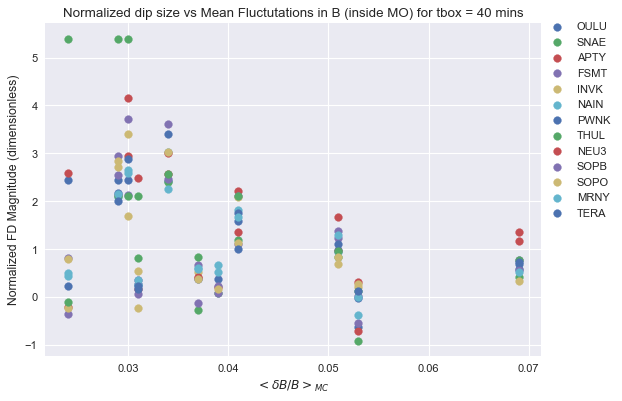

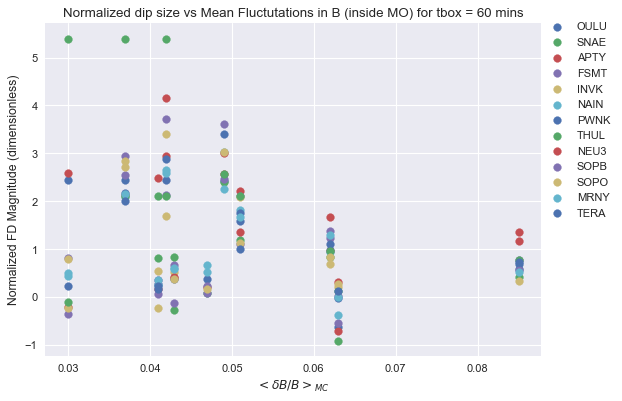

In [8]:
### Correlation plots with Delta B/B data - from ICME 151 to 141 (152 to 142 in Debesh's final thesis)

#dBBa = deltaB/B with tbox = 40 mins

# Making dBBa arrays specific to stations, removing elements corresponding to fdmags available
plt.style.use('seaborn')

dBBa1 = np.array([0.041, 0.069, 0.034, 0.051, 0.031, 0.039, 0.053, 0.030, 0.024, 0.029])
dBBa2 = np.array([0.041, 0.069, 0.034, 0.051, 0.037, 0.031, 0.053, 0.030, 0.024, 0.029])
dBBa3 = np.array([0.041, 0.069, 0.034, 0.051, 0.037, 0.031, 0.039, 0.053, 0.030, 0.024, 0.029])
dBBa4 = np.array([0.041, 0.069, 0.034, 0.051, 0.037, 0.031, 0.039, 0.053, 0.030, 0.024, 0.029])
dBBa5 = np.array([0.041, 0.051, 0.037, 0.031, 0.053, 0.030, 0.024, 0.029])
dBBa6 = np.array([0.041, 0.034, 0.051, 0.037, 0.031, 0.039, 0.053, 0.030, 0.024, 0.029])
dBBa7 = np.array([0.041, 0.069, 0.051, 0.037, 0.031, 0.053, 0.030, 0.024, 0.029])
dBBa8 = np.array([0.041, 0.069, 0.034, 0.051, 0.037, 0.031, 0.039, 0.053, 0.030, 0.024, 0.029])
dBBa9 = np.array([0.041, 0.069, 0.034, 0.051, 0.037, 0.031, 0.053, 0.030, 0.024])
dBBa10 = np.array([0.041, 0.069, 0.034, 0.051, 0.037, 0.031, 0.039, 0.053, 0.030, 0.024, 0.029])
dBBa11 = np.array([0.041, 0.069, 0.034, 0.051, 0.037, 0.031, 0.039, 0.053, 0.030, 0.024, 0.029])
dBBa12 = np.array([0.041, 0.069, 0.034, 0.051, 0.037, 0.031, 0.039, 0.053, 0.030, 0.024, 0.029])
dBBa13 = np.array([0.041, 0.069, 0.034, 0.031, 0.053, 0.029])


#dBBb = deltaB/B with tbox = 60 mins

# Making dBBb arrays specific to stations, removing elements corresponding to fdmags available

dBBb1 = np.array([0.051, 0.085, 0.049, 0.062, 0.041, 0.047, 0.063, 0.042, 0.030, 0.037])
dBBb2 = np.array([0.051, 0.085, 0.049, 0.062, 0.043, 0.041, 0.063, 0.042, 0.030, 0.037])
dBBb3 = np.array([0.051, 0.085, 0.049, 0.062, 0.043, 0.041, 0.047, 0.063, 0.042, 0.030, 0.037])
dBBb4 = np.array([0.051, 0.085, 0.049, 0.062, 0.043, 0.041, 0.047, 0.063, 0.042, 0.030, 0.037])
dBBb5 = np.array([0.051, 0.062, 0.043, 0.041, 0.063, 0.042, 0.030, 0.037])
dBBb6 = np.array([0.051, 0.049, 0.062, 0.043, 0.041, 0.047, 0.063, 0.042, 0.030, 0.037])
dBBb7 = np.array([0.051, 0.085, 0.062, 0.043, 0.041, 0.063, 0.042, 0.030, 0.037])
dBBb8 = np.array([0.051, 0.085, 0.049, 0.062, 0.043, 0.041, 0.047, 0.063, 0.042, 0.030, 0.037])
dBBb9 = np.array([0.051, 0.085, 0.049, 0.062, 0.043, 0.041, 0.063, 0.042, 0.030])
dBBb10 = np.array([0.051, 0.085, 0.049, 0.062, 0.043, 0.041, 0.047, 0.063, 0.042, 0.030, 0.037])
dBBb11 = np.array([0.051, 0.085, 0.049, 0.062, 0.043, 0.041, 0.047, 0.063, 0.042, 0.030, 0.037])
dBBb12 = np.array([0.051, 0.085, 0.049, 0.062, 0.043, 0.041, 0.047, 0.063, 0.042, 0.030, 0.037])
dBBb13 = np.array([0.051, 0.085, 0.049, 0.041, 0.063, 0.037])


# Plotting FD magnitude counts with dBBa

plt.scatter(dBBa1, fdmags_count_1, label="OULU")
plt.scatter(dBBa2, fdmags_count_2, label="SNAE")
plt.scatter(dBBa3, fdmags_count_3, label="APTY")
plt.scatter(dBBa4, fdmags_count_4, label="FSMT")
plt.scatter(dBBa5, fdmags_count_5, label="INVK")
plt.scatter(dBBa6, fdmags_count_6, label="NAIN")
plt.scatter(dBBa7, fdmags_count_7, label="PWNK")
plt.scatter(dBBa8, fdmags_count_8, label="THUL")
plt.scatter(dBBa9, fdmags_count_9, label="NEU3")
plt.scatter(dBBa10, fdmags_count_10, label="SOPB")
plt.scatter(dBBa11, fdmags_count_11, label="SOPO")
plt.scatter(dBBa12, fdmags_count_12, label="MRNY")
plt.scatter(dBBa13, fdmags_count_13, label="TERA")

plt.legend(loc=(1,0.40))
plt.xlabel(r"$<\delta B/B>_{MC}$")
plt.ylabel("Normalized FD Magnitude (dimensionless)")
plt.title("Normalized dip size vs Mean Fluctutations in B (inside MO) for tbox = 40 mins")
plt.style.use('seaborn')
plt.show()


# Plotting FD magnitude counts with dBBb

plt.scatter(dBBb1, fdmags_count_1, label="OULU")
plt.scatter(dBBb2, fdmags_count_2, label="SNAE")
plt.scatter(dBBb3, fdmags_count_3, label="APTY")
plt.scatter(dBBb4, fdmags_count_4, label="FSMT")
plt.scatter(dBBb5, fdmags_count_5, label="INVK")
plt.scatter(dBBb6, fdmags_count_6, label="NAIN")
plt.scatter(dBBb7, fdmags_count_7, label="PWNK")
plt.scatter(dBBb8, fdmags_count_8, label="THUL")
plt.scatter(dBBb9, fdmags_count_9, label="NEU3")
plt.scatter(dBBb10, fdmags_count_10, label="SOPB")
plt.scatter(dBBb11, fdmags_count_11, label="SOPO")
plt.scatter(dBBb12, fdmags_count_12, label="MRNY")
plt.scatter(dBBb13, fdmags_count_13, label="TERA")

plt.legend(loc=(1,0.40))
plt.xlabel(r"$<\delta B/B>_{MC}$")
plt.ylabel("Normalized FD Magnitude (dimensionless)")
plt.title("Normalized dip size vs Mean Fluctutations in B (inside MO) for tbox = 60 mins")
plt.style.use('seaborn')
plt.show()




Corresponding Pearson R values for 13 stations - 
[-0.60498262 -0.72706678 -0.17352652 -0.18981118 -0.09687499 -0.37559802
 -0.28428174 -0.23413847 -0.57314688 -0.37731609 -0.47554273 -0.36043012
 -0.43053018]
Average pearson r value =  -0.37717279357207895
Corresponding Spearman R values for 13 stations - 
[-0.69330372 -0.87736666 -0.10909091 -0.2        -0.02380952 -0.24848485
 -0.23333333 -0.19090909 -0.76666667 -0.39090909 -0.52727273 -0.28181818
 -0.42857143]
Average spearman r value =  -0.38242586045106264
Corresponding Kendall Tau values for 13 stations - 
[-0.55205245 -0.73606993 -0.05454545 -0.16363636 -0.07142857 -0.15555556
 -0.16666667 -0.12727273 -0.55555556 -0.23636364 -0.38181818 -0.2
 -0.33333333]
Average kendall tau value =  -0.28725372489346984
Corresponding linregress slope values for 13 stations - 
[ -49.20851068 -126.63770465  -16.15280465  -16.37715256  -10.13955752
  -44.60160134  -19.99429489  -16.8440105   -50.68464589  -41.2882726
  -44.14162777  -24.76288219 

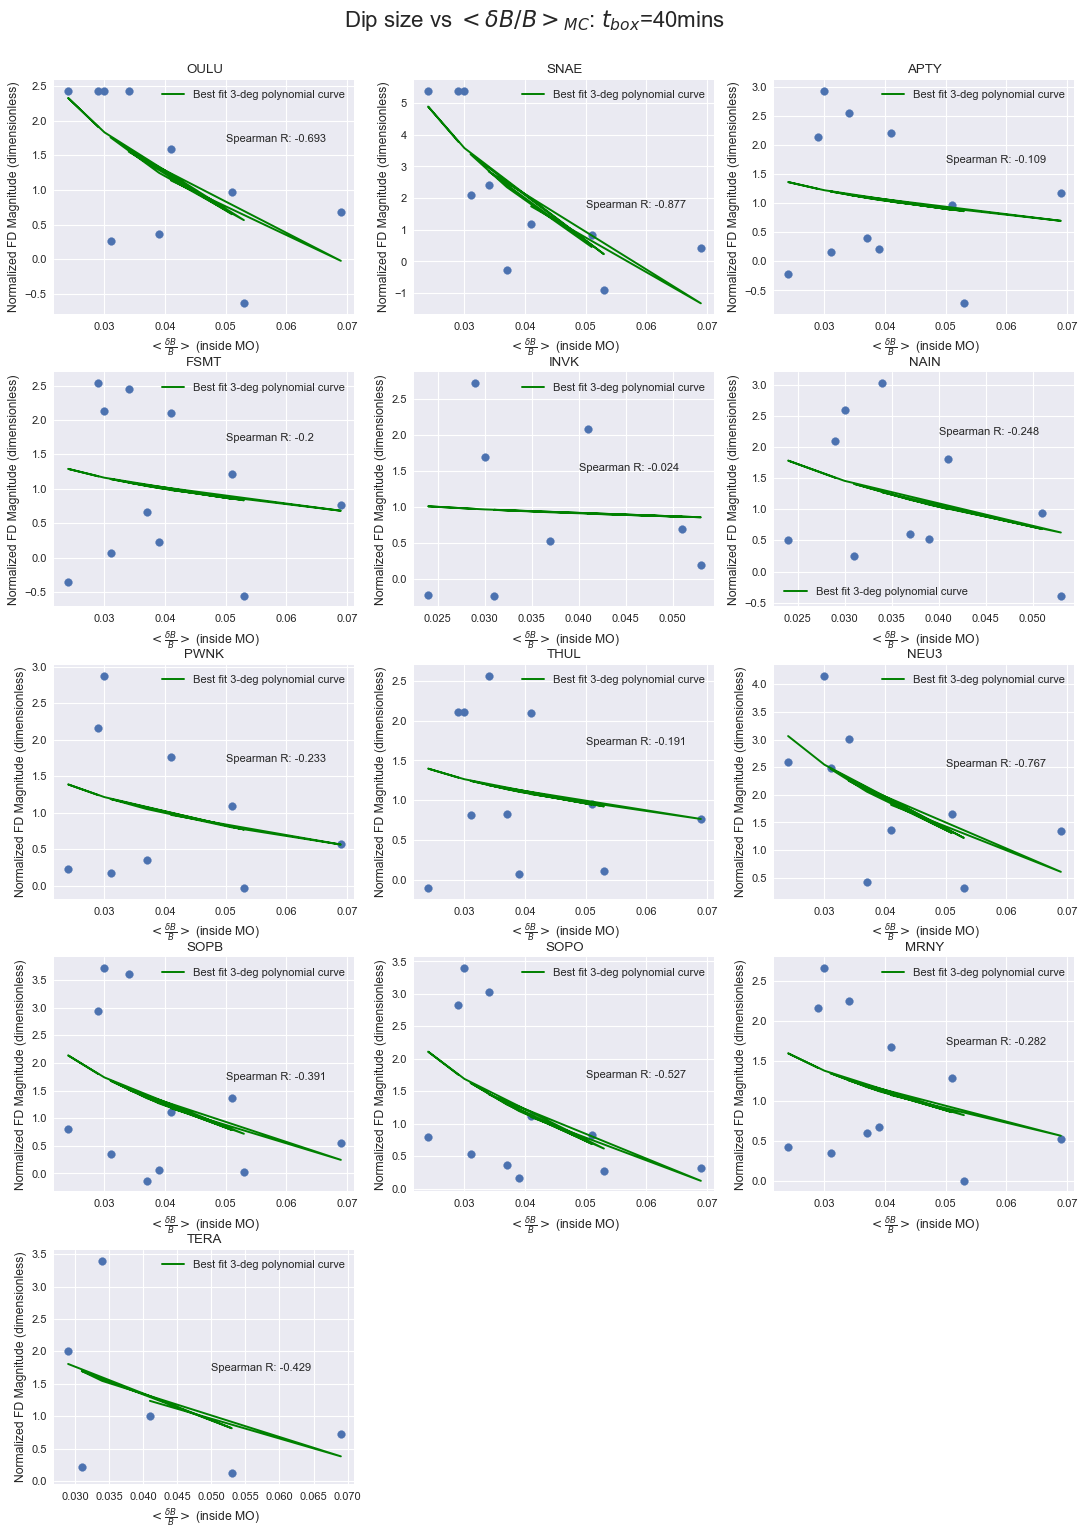

In [36]:
## Plotting dBBa vs dipsize station wise 

# Create a figure environment and define the size using the figsize argument
fig = plt.figure(figsize=(15, 15))

# Adding subplots 

ax1 = fig.add_subplot(531, title="OULU", xlabel = r"$<\frac{\delta B}{B}>$ (inside MO)",
                      ylabel = "Normalized FD Magnitude (dimensionless)" )
ax2 = fig.add_subplot(532, title="SNAE", xlabel = r"$<\frac{\delta B}{B}>$ (inside MO)",
                      ylabel = "Normalized FD Magnitude (dimensionless)" )
ax3 = fig.add_subplot(533, title="APTY", xlabel = r"$<\frac{\delta B}{B}>$ (inside MO)",
                      ylabel = "Normalized FD Magnitude (dimensionless)" )
ax4 = fig.add_subplot(534, title="FSMT", xlabel = r"$<\frac{\delta B}{B}>$ (inside MO)",
                      ylabel = "Normalized FD Magnitude (dimensionless)" )
ax5 = fig.add_subplot(535, title="INVK", xlabel = r"$<\frac{\delta B}{B}>$ (inside MO)",
                      ylabel = "Normalized FD Magnitude (dimensionless)" )
ax6 = fig.add_subplot(536, title="NAIN", xlabel = r"$<\frac{\delta B}{B}>$ (inside MO)",
                      ylabel = "Normalized FD Magnitude (dimensionless)" )
ax7 = fig.add_subplot(537, title="PWNK", xlabel = r"$<\frac{\delta B}{B}>$ (inside MO)",
                      ylabel = "Normalized FD Magnitude (dimensionless)" )
ax8 = fig.add_subplot(538, title="THUL", xlabel = r"$<\frac{\delta B}{B}>$ (inside MO)",
                      ylabel = "Normalized FD Magnitude (dimensionless)" )
ax9 = fig.add_subplot(539, title="NEU3", xlabel = r"$<\frac{\delta B}{B}>$ (inside MO)",
                      ylabel = "Normalized FD Magnitude (dimensionless)" )
ax10 = fig.add_subplot(5,3,10, title="SOPB", xlabel = r"$<\frac{\delta B}{B}>$ (inside MO)",
                      ylabel = "Normalized FD Magnitude (dimensionless)" )
ax11 = fig.add_subplot(5,3,11, title="SOPO", xlabel = r"$<\frac{\delta B}{B}>$ (inside MO)",
                      ylabel = "Normalized FD Magnitude (dimensionless)")
ax12 = fig.add_subplot(5,3,12, title="MRNY", xlabel = r"$<\frac{\delta B}{B}>$ (inside MO)",
                      ylabel = "Normalized FD Magnitude (dimensionless)")
ax13 = fig.add_subplot(5,3,13, title="TERA", xlabel = r"$<\frac{\delta B}{B}>$ (inside MO)",
                      ylabel = "Normalized FD Magnitude (dimensionless)")

# Defining 3rd degree polynomial function to best fit 
def f(x,a,b,c,d):
    return a + b*np.log(x) + c*np.log(x**2) + d*np.log(x**3)


# Populating individual graphs with corresponding data


ax1.scatter(dBBa1, fdmagsfl_count_1)
popt, cov = curve_fit(f, dBBa1, fdmagsfl_count_1)
p,q,r,s = popt
ax1.plot(dBBa1, f(dBBa1, p,q,r,s), 'g', label="Best fit 3-deg polynomial curve")
ax1.text(0.05, 1.7, f"Spearman R: {np.round(sct.spearmanr(dBBa1, fdmagsfl_count_1)[0],3)}")
ax1.legend()


ax2.scatter(dBBa2, fdmagsfl_count_2)
popt, cov = curve_fit(f, dBBa2, fdmagsfl_count_2)
p,q,r,s = popt
ax2.plot(dBBa2, f(dBBa2, p,q,r,s), 'g', label="Best fit 3-deg polynomial curve")
ax2.text(0.05, 1.7, f"Spearman R: {np.round(sct.spearmanr(dBBa2, fdmagsfl_count_2)[0],3)}")
ax2.legend()


ax3.scatter(dBBa3, fdmagsfl_count_3)
popt, cov = curve_fit(f, dBBa3, fdmagsfl_count_3)
p,q,r,s = popt
ax3.plot(dBBa3, f(dBBa3, p,q,r,s), 'g', label="Best fit 3-deg polynomial curve")
ax3.text(0.05, 1.7, f"Spearman R: {np.round(sct.spearmanr(dBBa3, fdmagsfl_count_3)[0],3)}")
ax3.legend()

ax4.scatter(dBBa4, fdmagsfl_count_4)
popt, cov = curve_fit(f, dBBa4, fdmagsfl_count_4)
p,q,r,s = popt
ax4.plot(dBBa4, f(dBBa4, p,q,r,s), 'g', label="Best fit 3-deg polynomial curve")
ax4.text(0.05, 1.7, f"Spearman R: {np.round(sct.spearmanr(dBBa4, fdmagsfl_count_4)[0],3)}")
ax4.legend()

ax5.scatter(dBBa5, fdmagsfl_count_5)
popt, cov = curve_fit(f, dBBa5, fdmagsfl_count_5)
p,q,r,s = popt
ax5.plot(dBBa5, f(dBBa5, p,q,r,s), 'g', label="Best fit 3-deg polynomial curve")
ax5.text(0.04, 1.5, f"Spearman R: {np.round(sct.spearmanr(dBBa5, fdmagsfl_count_5)[0],3)}")
ax5.legend()

ax6.scatter(dBBa6, fdmagsfl_count_6)
popt, cov = curve_fit(f, dBBa6, fdmagsfl_count_6)
p,q,r,s = popt
ax6.plot(dBBa6, f(dBBa6, p,q,r,s), 'g', label="Best fit 3-deg polynomial curve")
ax6.text(0.040, 2.2, f"Spearman R: {np.round(sct.spearmanr(dBBa6, fdmagsfl_count_6)[0],3)}")
ax6.legend()

ax7.scatter(dBBa7, fdmagsfl_count_7)
popt, cov = curve_fit(f, dBBa7, fdmagsfl_count_7)
p,q,r,s = popt
ax7.plot(dBBa7, f(dBBa7, p,q,r,s), 'g', label="Best fit 3-deg polynomial curve")
ax7.text(0.05, 1.7, f"Spearman R: {np.round(sct.spearmanr(dBBa7, fdmagsfl_count_7)[0],3)}")
ax7.legend()

ax8.scatter(dBBa8, fdmagsfl_count_8)
popt, cov = curve_fit(f, dBBa8, fdmagsfl_count_8)
p,q,r,s = popt
ax8.plot(dBBa8, f(dBBa8, p,q,r,s), 'g', label="Best fit 3-deg polynomial curve")
ax8.text(0.05, 1.7, f"Spearman R: {np.round(sct.spearmanr(dBBa8, fdmagsfl_count_8)[0],3)}")
ax8.legend()

ax9.scatter(dBBa9, fdmagsfl_count_9)
popt, cov = curve_fit(f, dBBa9, fdmagsfl_count_9)
p,q,r,s = popt
ax9.plot(dBBa9, f(dBBa9, p,q,r,s), 'g', label="Best fit 3-deg polynomial curve")
ax9.text(0.05, 2.5, f"Spearman R: {np.round(sct.spearmanr(dBBa9, fdmagsfl_count_9)[0],3)}")
ax9.legend()

ax10.scatter(dBBa10, fdmagsfl_count_10)
popt, cov = curve_fit(f, dBBa10, fdmagsfl_count_10)
p,q,r,s = popt
ax10.plot(dBBa10, f(dBBa10, p,q,r,s), 'g', label="Best fit 3-deg polynomial curve")
ax10.text(0.05, 1.7, f"Spearman R: {np.round(sct.spearmanr(dBBa10, fdmagsfl_count_10)[0],3)}")
ax10.legend()


ax11.scatter(dBBa11, fdmagsfl_count_11)
popt, cov = curve_fit(f, dBBa11, fdmagsfl_count_11)
p,q,r,s = popt
ax11.plot(dBBa11, f(dBBa11, p,q,r,s), 'g', label="Best fit 3-deg polynomial curve")
ax11.text(0.05, 1.7, f"Spearman R: {np.round(sct.spearmanr(dBBa11, fdmagsfl_count_11)[0],3)}")
ax11.legend()


ax12.scatter(dBBa12, fdmagsfl_count_12)
popt, cov = curve_fit(f, dBBa12, fdmagsfl_count_12)
p,q,r,s = popt
ax12.plot(dBBa12, f(dBBa12, p,q,r,s), 'g', label="Best fit 3-deg polynomial curve")
ax12.text(0.05, 1.7, f"Spearman R: {np.round(sct.spearmanr(dBBa12, fdmagsfl_count_12)[0],3)}")
ax12.legend()


ax13.scatter(dBBa13, fdmagsfl_count_13)
popt, cov = curve_fit(f, dBBa13, fdmagsfl_count_13)
p,q,r,s = popt
ax13.plot(dBBa13, f(dBBa13, p,q,r,s), 'g', label="Best fit 3-deg polynomial curve")
ax13.text(0.05, 1.7, f"Spearman R: {np.round(sct.spearmanr(dBBa13, fdmagsfl_count_13)[0],3)}")
ax13.legend()


plt.suptitle(r"Dip size vs $<\delta B/B>_{MC}$: $t_{box}$=40mins", fontsize=20, y=1.24)



fig.subplots_adjust(hspace=0.25, wspace=0.20, left=0.1, right=0.95,
                    bottom=0.01, top=1.18)


## Analyzing correlation coefficients - 

# NumPy np.corrcoef() gives same as scipy.stats.pearsonr()

# SciPy pearson R values = scpr  (linregress returns the same values)

scpr = np.array([ sct.pearsonr(dBBa1, fdmagsfl_count_1)[0], sct.pearsonr(dBBa2, fdmagsfl_count_2)[0], 
                  sct.pearsonr(dBBa3, fdmagsfl_count_3)[0], sct.pearsonr(dBBa4, fdmagsfl_count_4)[0], 
                  sct.pearsonr(dBBa5, fdmagsfl_count_5)[0], sct.pearsonr(dBBa6, fdmagsfl_count_6)[0], 
                  sct.pearsonr(dBBa7, fdmagsfl_count_7)[0], sct.pearsonr(dBBa8, fdmagsfl_count_8)[0], 
                  sct.pearsonr(dBBa9, fdmagsfl_count_9)[0], sct.pearsonr(dBBa10, fdmagsfl_count_10)[0], 
                  sct.pearsonr(dBBa11, fdmagsfl_count_11)[0], sct.pearsonr(dBBa12, fdmagsfl_count_12)[0], 
                  sct.pearsonr(dBBa13, fdmagsfl_count_13)[0]])

# SciPy spearman r values = scsr

scsr = np.array([ sct.spearmanr(dBBa1, fdmagsfl_count_1)[0],sct.spearmanr(dBBa2, fdmagsfl_count_2)[0],
                  sct.spearmanr(dBBa3, fdmagsfl_count_3)[0],sct.spearmanr(dBBa4, fdmagsfl_count_4)[0],
                  sct.spearmanr(dBBa5, fdmagsfl_count_5)[0],sct.spearmanr(dBBa6, fdmagsfl_count_6)[0],
                  sct.spearmanr(dBBa7, fdmagsfl_count_7)[0],sct.spearmanr(dBBa8, fdmagsfl_count_8)[0],
                  sct.spearmanr(dBBa9, fdmagsfl_count_9)[0],sct.spearmanr(dBBa10, fdmagsfl_count_10)[0],
                  sct.spearmanr(dBBa11, fdmagsfl_count_11)[0],sct.spearmanr(dBBa12, fdmagsfl_count_12)[0],
                  sct.spearmanr(dBBa13, fdmagsfl_count_13)[0]])

# SciPy kendall tau values = sckt

sckt = np.array([ sct.kendalltau(dBBa1, fdmagsfl_count_1)[0], sct.kendalltau(dBBa2, fdmagsfl_count_2)[0], 
                  sct.kendalltau(dBBa3, fdmagsfl_count_3)[0], sct.kendalltau(dBBa4, fdmagsfl_count_4)[0],
                  sct.kendalltau(dBBa5, fdmagsfl_count_5)[0], sct.kendalltau(dBBa6, fdmagsfl_count_6)[0], 
                  sct.kendalltau(dBBa7, fdmagsfl_count_7)[0], sct.kendalltau(dBBa8, fdmagsfl_count_8)[0], 
                  sct.kendalltau(dBBa9, fdmagsfl_count_9)[0], sct.kendalltau(dBBa10, fdmagsfl_count_10)[0],
                  sct.kendalltau(dBBa11, fdmagsfl_count_11)[0], sct.kendalltau(dBBa12, fdmagsfl_count_12)[0],
                  sct.kendalltau(dBBa13, fdmagsfl_count_13)[0]])


# SciPy linear regression slope values give strength of correlation - sclrm

sclrm = np.array([ sct.linregress(dBBa1, fdmagsfl_count_1)[0], sct.linregress(dBBa2, fdmagsfl_count_2)[0],
                  sct.linregress(dBBa3, fdmagsfl_count_3)[0], sct.linregress(dBBa4, fdmagsfl_count_4)[0], 
                  sct.linregress(dBBa5, fdmagsfl_count_5)[0], sct.linregress(dBBa6, fdmagsfl_count_6)[0],
                  sct.linregress(dBBa7, fdmagsfl_count_7)[0], sct.linregress(dBBa8, fdmagsfl_count_8)[0], 
                  sct.linregress(dBBa9, fdmagsfl_count_9)[0], sct.linregress(dBBa10, fdmagsfl_count_10)[0], 
                  sct.linregress(dBBa11, fdmagsfl_count_11)[0], sct.linregress(dBBa12, fdmagsfl_count_12)[0],
                  sct.linregress(dBBa13, fdmagsfl_count_13)[0]])

## Estimating error in linregress slop - sclre

sclre = np.array([ sct.linregress(dBBa1, fdmagsfl_count_1)[4], sct.linregress(dBBa2, fdmagsfl_count_2)[4],
                  sct.linregress(dBBa3, fdmagsfl_count_3)[4], sct.linregress(dBBa4, fdmagsfl_count_4)[4], 
                  sct.linregress(dBBa5, fdmagsfl_count_5)[4], sct.linregress(dBBa6, fdmagsfl_count_6)[4],
                  sct.linregress(dBBa7, fdmagsfl_count_7)[4], sct.linregress(dBBa8, fdmagsfl_count_8)[4], 
                  sct.linregress(dBBa9, fdmagsfl_count_9)[4], sct.linregress(dBBa10, fdmagsfl_count_10)[4], 
                  sct.linregress(dBBa11, fdmagsfl_count_11)[4], sct.linregress(dBBa12, fdmagsfl_count_12)[4],
                  sct.linregress(dBBa13, fdmagsfl_count_13)[4]])



print(f"Corresponding Pearson R values for 13 stations - ")
print(scpr)
print("Average pearson r value = ", np.mean(scpr)) 

print(f"Corresponding Spearman R values for 13 stations - ")
print(scsr)
print("Average spearman r value = ", np.mean(scsr))

print(f"Corresponding Kendall Tau values for 13 stations - ")
print(sckt)
print("Average kendall tau value = ", np.mean(sckt))

print(f"Corresponding linregress slope values for 13 stations - ")
print(sclrm)
print("Average linregress slope value = ", np.mean(sclrm))

print("Average error in linregress slope = ", np.mean(sclre))



In [10]:
## Analyzing correlation coefficients - 

# NumPy np.corrcoef() gives same as scipy.stats.pearsonr()

# SciPy pearson R values = scpr  (linregress returns the same values)

scpr = np.array([ sct.pearsonr(dBBa1, fdmagsfl_count_1)[0], sct.pearsonr(dBBa2, fdmagsfl_count_2)[0], 
                  sct.pearsonr(dBBa3, fdmagsfl_count_3)[0], sct.pearsonr(dBBa4, fdmagsfl_count_4)[0], 
                  sct.pearsonr(dBBa5, fdmagsfl_count_5)[0], sct.pearsonr(dBBa6, fdmagsfl_count_6)[0], 
                  sct.pearsonr(dBBa7, fdmagsfl_count_7)[0], sct.pearsonr(dBBa8, fdmagsfl_count_8)[0], 
                  sct.pearsonr(dBBa9, fdmagsfl_count_9)[0], sct.pearsonr(dBBa10, fdmagsfl_count_10)[0], 
                  sct.pearsonr(dBBa11, fdmagsfl_count_11)[0], sct.pearsonr(dBBa12, fdmagsfl_count_12)[0], 
                  sct.pearsonr(dBBa13, fdmagsfl_count_13)[0]])

# SciPy spearman r values = scsr

scsr = np.array([ sct.spearmanr(dBBa1, fdmagsfl_count_1)[0],sct.spearmanr(dBBa2, fdmagsfl_count_2)[0],
                  sct.spearmanr(dBBa3, fdmagsfl_count_3)[0],sct.spearmanr(dBBa4, fdmagsfl_count_4)[0],
                  sct.spearmanr(dBBa5, fdmagsfl_count_5)[0],sct.spearmanr(dBBa6, fdmagsfl_count_6)[0],
                  sct.spearmanr(dBBa7, fdmagsfl_count_7)[0],sct.spearmanr(dBBa8, fdmagsfl_count_8)[0],
                  sct.spearmanr(dBBa9, fdmagsfl_count_9)[0],sct.spearmanr(dBBa10, fdmagsfl_count_10)[0],
                  sct.spearmanr(dBBa11, fdmagsfl_count_11)[0],sct.spearmanr(dBBa12, fdmagsfl_count_12)[0],
                  sct.spearmanr(dBBa13, fdmagsfl_count_13)[0]])

# SciPy kendall tau values = sckt

sckt = np.array([ sct.kendalltau(dBBa1, fdmagsfl_count_1)[0], sct.kendalltau(dBBa2, fdmagsfl_count_2)[0], 
                  sct.kendalltau(dBBa3, fdmagsfl_count_3)[0], sct.kendalltau(dBBa4, fdmagsfl_count_4)[0],
                  sct.kendalltau(dBBa5, fdmagsfl_count_5)[0], sct.kendalltau(dBBa6, fdmagsfl_count_6)[0], 
                  sct.kendalltau(dBBa7, fdmagsfl_count_7)[0], sct.kendalltau(dBBa8, fdmagsfl_count_8)[0], 
                  sct.kendalltau(dBBa9, fdmagsfl_count_9)[0], sct.kendalltau(dBBa10, fdmagsfl_count_10)[0],
                  sct.kendalltau(dBBa11, fdmagsfl_count_11)[0], sct.kendalltau(dBBa12, fdmagsfl_count_12)[0],
                  sct.kendalltau(dBBa13, fdmagsfl_count_13)[0]])


# SciPy linear regression slope values give strength of correlation - sclrm

sclrm = np.array([ sct.linregress(dBBa1, fdmagsfl_count_1)[0], sct.linregress(dBBa2, fdmagsfl_count_2)[0],
                  sct.linregress(dBBa3, fdmagsfl_count_3)[0], sct.linregress(dBBa4, fdmagsfl_count_4)[0], 
                  sct.linregress(dBBa5, fdmagsfl_count_5)[0], sct.linregress(dBBa6, fdmagsfl_count_6)[0],
                  sct.linregress(dBBa7, fdmagsfl_count_7)[0], sct.linregress(dBBa8, fdmagsfl_count_8)[0], 
                  sct.linregress(dBBa9, fdmagsfl_count_9)[0], sct.linregress(dBBa10, fdmagsfl_count_10)[0], 
                  sct.linregress(dBBa11, fdmagsfl_count_11)[0], sct.linregress(dBBa12, fdmagsfl_count_12)[0],
                  sct.linregress(dBBa13, fdmagsfl_count_13)[0]])

## Estimating error in linregress slop - sclre

sclre = np.array([ sct.linregress(dBBa1, fdmagsfl_count_1)[4], sct.linregress(dBBa2, fdmagsfl_count_2)[4],
                  sct.linregress(dBBa3, fdmagsfl_count_3)[4], sct.linregress(dBBa4, fdmagsfl_count_4)[4], 
                  sct.linregress(dBBa5, fdmagsfl_count_5)[4], sct.linregress(dBBa6, fdmagsfl_count_6)[4],
                  sct.linregress(dBBa7, fdmagsfl_count_7)[4], sct.linregress(dBBa8, fdmagsfl_count_8)[4], 
                  sct.linregress(dBBa9, fdmagsfl_count_9)[4], sct.linregress(dBBa10, fdmagsfl_count_10)[4], 
                  sct.linregress(dBBa11, fdmagsfl_count_11)[4], sct.linregress(dBBa12, fdmagsfl_count_12)[4],
                  sct.linregress(dBBa13, fdmagsfl_count_13)[4]])




print("Average pearson r value = ", np.mean(scpr))
print("Average spearman r value = ", np.mean(scsr))
print("Average kendall tau value = ", np.mean(sckt))
print("Average linregress slope value = ", np.mean(sclrm))
print("Average error in linregress slope = ", np.mean(sclre))



Average pearson r value =  -0.37717279357207895
Average spearman r value =  -0.38242586045106264
Average kendall tau value =  -0.28725372489346984
Average linregress slope value =  -38.13299271023147
Average error in linregress slope =  30.81070628600654


Corresponding Pearson R values for 13 stations - 
[-0.53572151 -0.67130707 -0.04781456 -0.08595945 -0.04404769 -0.18436231
 -0.21079111 -0.11160273 -0.44141542 -0.24073824 -0.34973583 -0.24735408
 -0.32492465]
Average pearson r value =  -0.26890574282047386
Corresponding Spearman R values for 13 stations - 
[-0.55832424 -0.77919976  0.06363636 -0.04545455  0.0952381  -0.03030303
 -0.11666667 -0.01818182 -0.61666667 -0.18181818 -0.33636364 -0.11818182
 -0.42857143]
Average spearman r value =  -0.23621979485063102
Corresponding Kendall Tau values for 13 stations - 
[-0.46004371 -0.64406119  0.05454545 -0.05454545  0.         -0.02222222
 -0.11111111 -0.01818182 -0.44444444 -0.12727273 -0.27272727 -0.09090909
 -0.33333333]
Average kendall tau value =  -0.19417745501152206
Corresponding linregress slope values for 13 stations - 
[ -38.10644349 -101.50444951   -3.85636156   -6.42607343   -4.17844011
  -19.92481916  -12.73109879   -6.95637545  -34.05856475  -22.82453365
  -28.12771031  -14.7

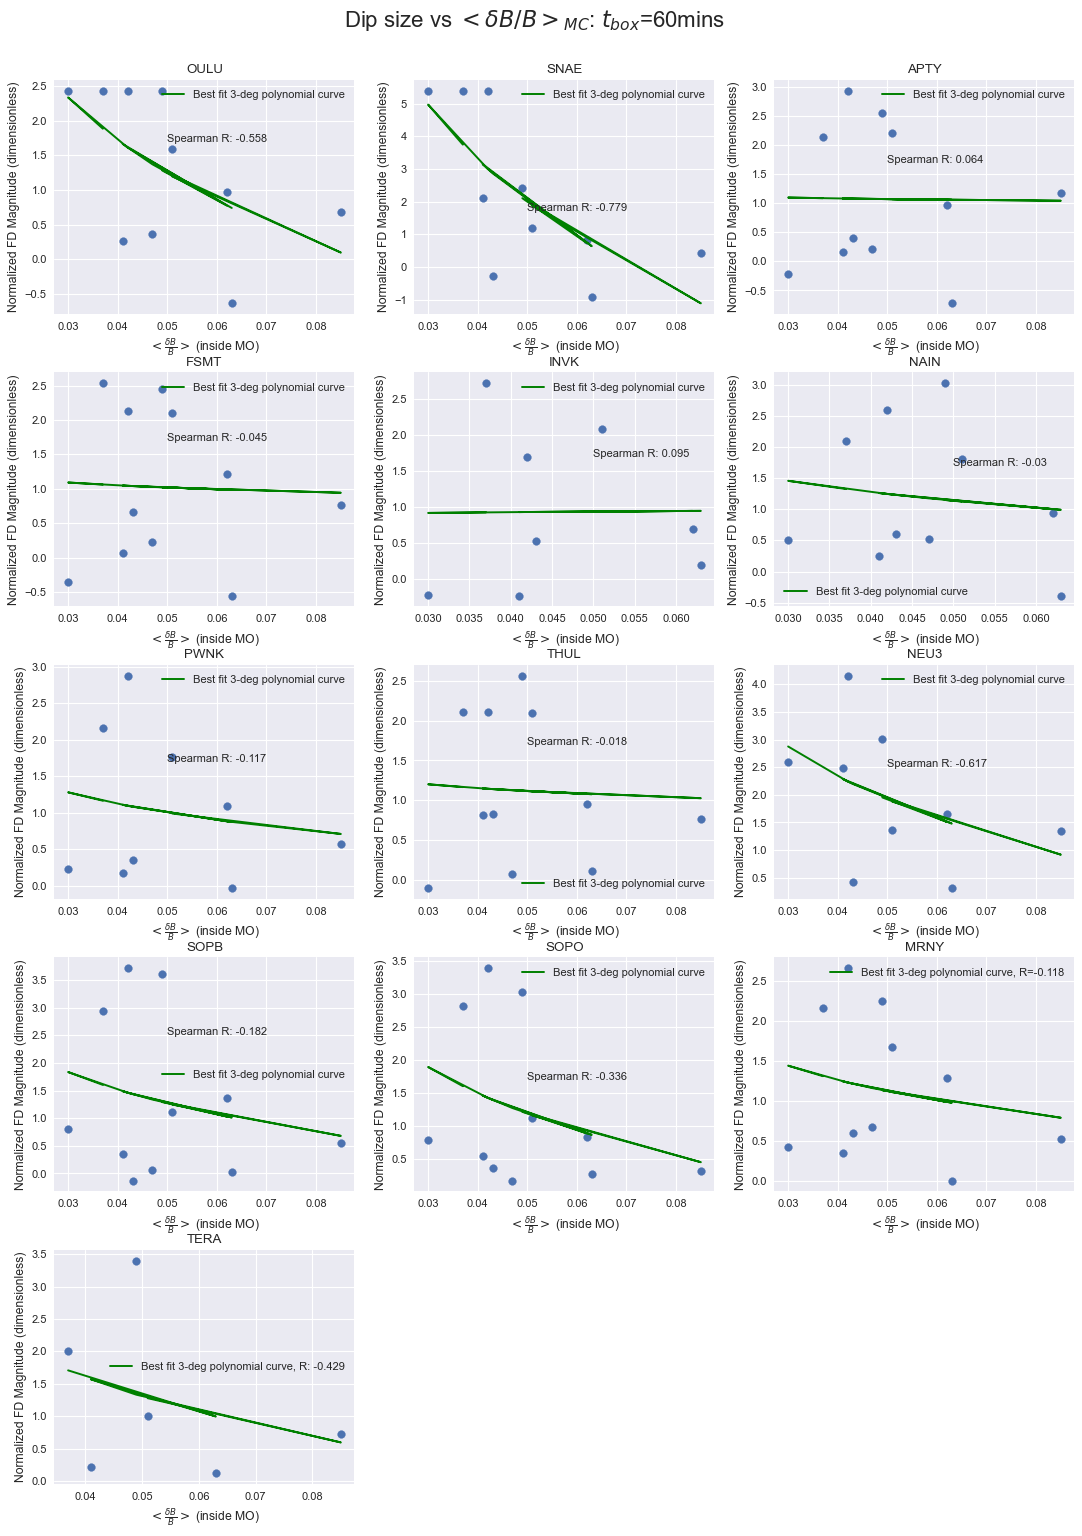

In [37]:
## Plotting dBBb vs dipsize station wise 

# Create a figure environment and define the size using the figsize argument
fig = plt.figure(figsize=(15, 15))

# Adding subplots 

ax1 = fig.add_subplot(531, title="OULU", xlabel = r"$<\frac{\delta B}{B}>$ (inside MO)",
                      ylabel = "Normalized FD Magnitude (dimensionless)" )
ax2 = fig.add_subplot(532, title="SNAE", xlabel = r"$<\frac{\delta B}{B}>$ (inside MO)",
                      ylabel = "Normalized FD Magnitude (dimensionless)" )
ax3 = fig.add_subplot(533, title="APTY", xlabel = r"$<\frac{\delta B}{B}>$ (inside MO)",
                      ylabel = "Normalized FD Magnitude (dimensionless)" )
ax4 = fig.add_subplot(534, title="FSMT", xlabel = r"$<\frac{\delta B}{B}>$ (inside MO)",
                      ylabel = "Normalized FD Magnitude (dimensionless)" )
ax5 = fig.add_subplot(535, title="INVK", xlabel = r"$<\frac{\delta B}{B}>$ (inside MO)",
                      ylabel = "Normalized FD Magnitude (dimensionless)" )
ax6 = fig.add_subplot(536, title="NAIN", xlabel = r"$<\frac{\delta B}{B}>$ (inside MO)",
                      ylabel = "Normalized FD Magnitude (dimensionless)" )
ax7 = fig.add_subplot(537, title="PWNK", xlabel = r"$<\frac{\delta B}{B}>$ (inside MO)",
                      ylabel = "Normalized FD Magnitude (dimensionless)" )
ax8 = fig.add_subplot(538, title="THUL", xlabel = r"$<\frac{\delta B}{B}>$ (inside MO)",
                      ylabel = "Normalized FD Magnitude (dimensionless)" )
ax9 = fig.add_subplot(539, title="NEU3", xlabel = r"$<\frac{\delta B}{B}>$ (inside MO)",
                      ylabel = "Normalized FD Magnitude (dimensionless)" )
ax10 = fig.add_subplot(5,3,10, title="SOPB", xlabel = r"$<\frac{\delta B}{B}>$ (inside MO)",
                      ylabel = "Normalized FD Magnitude (dimensionless)" )
ax11 = fig.add_subplot(5,3,11, title="SOPO", xlabel = r"$<\frac{\delta B}{B}>$ (inside MO)",
                      ylabel = "Normalized FD Magnitude (dimensionless)")
ax12 = fig.add_subplot(5,3,12, title="MRNY", xlabel = r"$<\frac{\delta B}{B}>$ (inside MO)",
                      ylabel = "Normalized FD Magnitude (dimensionless)")
ax13 = fig.add_subplot(5,3,13, title="TERA", xlabel = r"$<\frac{\delta B}{B}>$ (inside MO)",
                      ylabel = "Normalized FD Magnitude (dimensionless)")

# Defining 3rd degree polynomial function to best fit 
def f(x,a,b,c,d):
    return a + b*np.log(x) + c*np.log(x**2) + d*np.log(x**3)


# Populating individual graphs with corresponding data


ax1.scatter(dBBb1, fdmagsfl_count_1)
popt, cov = curve_fit(f, dBBb1, fdmagsfl_count_1)
p,q,r,s = popt
ax1.plot(dBBb1, f(dBBb1, p,q,r,s), 'g', label="Best fit 3-deg polynomial curve")
ax1.text(0.05, 1.7, f"Spearman R: {np.round(sct.spearmanr(dBBb1, fdmagsfl_count_1)[0],3)}")
ax1.legend()


ax2.scatter(dBBb2, fdmagsfl_count_2)
popt, cov = curve_fit(f, dBBb2, fdmagsfl_count_2)
p,q,r,s = popt
ax2.plot(dBBb2, f(dBBb2, p,q,r,s), 'g', label="Best fit 3-deg polynomial curve")
ax2.text(0.05, 1.7, f"Spearman R: {np.round(sct.spearmanr(dBBb2, fdmagsfl_count_2)[0],3)}")
ax2.legend()


ax3.scatter(dBBb3, fdmagsfl_count_3)
popt, cov = curve_fit(f, dBBb3, fdmagsfl_count_3)
p,q,r,s = popt
ax3.plot(dBBb3, f(dBBb3, p,q,r,s), 'g', label="Best fit 3-deg polynomial curve")
ax3.text(0.05, 1.7, f"Spearman R: {np.round(sct.spearmanr(dBBb3, fdmagsfl_count_3)[0],3)}")
ax3.legend()

ax4.scatter(dBBb4, fdmagsfl_count_4)
popt, cov = curve_fit(f, dBBb4, fdmagsfl_count_4)
p,q,r,s = popt
ax4.plot(dBBb4, f(dBBb4, p,q,r,s), 'g', label="Best fit 3-deg polynomial curve")
ax4.text(0.05, 1.7, f"Spearman R: {np.round(sct.spearmanr(dBBb4, fdmagsfl_count_4)[0],3)}")
ax4.legend()

ax5.scatter(dBBb5, fdmagsfl_count_5)
popt, cov = curve_fit(f, dBBb5, fdmagsfl_count_5)
p,q,r,s = popt
ax5.plot(dBBb5, f(dBBb5, p,q,r,s), 'g', label="Best fit 3-deg polynomial curve")
ax5.text(0.05, 1.7, f"Spearman R: {np.round(sct.spearmanr(dBBb5, fdmagsfl_count_5)[0],3)}")
ax5.legend()

ax6.scatter(dBBb6, fdmagsfl_count_6)
popt, cov = curve_fit(f, dBBb6, fdmagsfl_count_6)
p,q,r,s = popt
ax6.plot(dBBb6, f(dBBb6, p,q,r,s), 'g', label="Best fit 3-deg polynomial curve")
ax6.text(0.05, 1.7, f"Spearman R: {np.round(sct.spearmanr(dBBb6, fdmagsfl_count_6)[0],3)}")
ax6.legend()

ax7.scatter(dBBb7, fdmagsfl_count_7)
popt, cov = curve_fit(f, dBBb7, fdmagsfl_count_7)
p,q,r,s = popt
ax7.plot(dBBb7, f(dBBb7, p,q,r,s), 'g', label="Best fit 3-deg polynomial curve")
ax7.text(0.05, 1.7, f"Spearman R: {np.round(sct.spearmanr(dBBb7, fdmagsfl_count_7)[0],3)}")
ax7.legend()

ax8.scatter(dBBb8, fdmagsfl_count_8)
popt, cov = curve_fit(f, dBBb8, fdmagsfl_count_8)
p,q,r,s = popt
ax8.plot(dBBb8, f(dBBb8, p,q,r,s), 'g', label="Best fit 3-deg polynomial curve")
ax8.text(0.05, 1.7, f"Spearman R: {np.round(sct.spearmanr(dBBb8, fdmagsfl_count_8)[0],3)}")
ax8.legend()

ax9.scatter(dBBb9, fdmagsfl_count_9)
popt, cov = curve_fit(f, dBBb9, fdmagsfl_count_9)
p,q,r,s = popt
ax9.plot(dBBb9, f(dBBb9, p,q,r,s), 'g', label="Best fit 3-deg polynomial curve")
ax9.text(0.05, 2.5, f"Spearman R: {np.round(sct.spearmanr(dBBb9, fdmagsfl_count_9)[0],3)}")
ax9.legend()

ax10.scatter(dBBb10, fdmagsfl_count_10)
popt, cov = curve_fit(f, dBBb10, fdmagsfl_count_10)
p,q,r,s = popt
ax10.plot(dBBb10, f(dBBb10, p,q,r,s), 'g', label="Best fit 3-deg polynomial curve")
ax10.text(0.05, 2.5, f"Spearman R: {np.round(sct.spearmanr(dBBb10, fdmagsfl_count_10)[0],3)}")
ax10.legend()


ax11.scatter(dBBb11, fdmagsfl_count_11)
popt, cov = curve_fit(f, dBBb11, fdmagsfl_count_11)
p,q,r,s = popt
ax11.plot(dBBb11, f(dBBb11, p,q,r,s), 'g', label="Best fit 3-deg polynomial curve")
ax11.text(0.05, 1.7, f"Spearman R: {np.round(sct.spearmanr(dBBb11, fdmagsfl_count_11)[0],3)}")
ax11.legend()


ax12.scatter(dBBb12, fdmagsfl_count_12)
popt, cov = curve_fit(f, dBBb12, fdmagsfl_count_12)
p,q,r,s = popt
ax12.plot(dBBb12, f(dBBb12, p,q,r,s), 'g', label= f"Best fit 3-deg polynomial curve, R={np.round(sct.spearmanr(dBBb12, fdmagsfl_count_12)[0],3)}") 
ax12.legend()


ax13.scatter(dBBb13, fdmagsfl_count_13)
popt, cov = curve_fit(f, dBBb13, fdmagsfl_count_13)
p,q,r,s = popt
ax13.plot(dBBb13, f(dBBb13, p,q,r,s), 'g', label= f"Best fit 3-deg polynomial curve, R: {np.round(sct.spearmanr(dBBb13, fdmagsfl_count_13)[0],3)}")
ax13.legend()


plt.suptitle(r"Dip size vs $<\delta B/B>_{MC}$: $t_{box}$=60mins", fontsize=20, y=1.24)



fig.subplots_adjust(hspace=0.25, wspace=0.20, left=0.1, right=0.95,
                    bottom=0.01, top=1.18)


## Analyzing correlation coefficients - 

# NumPy np.corrcoef() gives same as scipy.stats.pearsonr()

# SciPy pearson R values = scpr  (linregress returns the same values)

scpr = np.array([ sct.pearsonr(dBBb1, fdmagsfl_count_1)[0], sct.pearsonr(dBBb2, fdmagsfl_count_2)[0], 
                  sct.pearsonr(dBBb3, fdmagsfl_count_3)[0], sct.pearsonr(dBBb4, fdmagsfl_count_4)[0], 
                  sct.pearsonr(dBBb5, fdmagsfl_count_5)[0], sct.pearsonr(dBBb6, fdmagsfl_count_6)[0], 
                  sct.pearsonr(dBBb7, fdmagsfl_count_7)[0], sct.pearsonr(dBBb8, fdmagsfl_count_8)[0], 
                  sct.pearsonr(dBBb9, fdmagsfl_count_9)[0], sct.pearsonr(dBBb10, fdmagsfl_count_10)[0], 
                  sct.pearsonr(dBBb11, fdmagsfl_count_11)[0], sct.pearsonr(dBBb12, fdmagsfl_count_12)[0], 
                  sct.pearsonr(dBBb13, fdmagsfl_count_13)[0]])

# SciPy spearman r values = scsr

scsr = np.array([ sct.spearmanr(dBBb1, fdmagsfl_count_1)[0],sct.spearmanr(dBBb2, fdmagsfl_count_2)[0],
                  sct.spearmanr(dBBb3, fdmagsfl_count_3)[0],sct.spearmanr(dBBb4, fdmagsfl_count_4)[0],
                  sct.spearmanr(dBBb5, fdmagsfl_count_5)[0],sct.spearmanr(dBBb6, fdmagsfl_count_6)[0],
                  sct.spearmanr(dBBb7, fdmagsfl_count_7)[0],sct.spearmanr(dBBb8, fdmagsfl_count_8)[0],
                  sct.spearmanr(dBBb9, fdmagsfl_count_9)[0],sct.spearmanr(dBBb10, fdmagsfl_count_10)[0],
                  sct.spearmanr(dBBb11, fdmagsfl_count_11)[0],sct.spearmanr(dBBb12, fdmagsfl_count_12)[0],
                  sct.spearmanr(dBBb13, fdmagsfl_count_13)[0]])

# SciPy kendall tau values = sckt

sckt = np.array([ sct.kendalltau(dBBb1, fdmagsfl_count_1)[0], sct.kendalltau(dBBb2, fdmagsfl_count_2)[0], 
                  sct.kendalltau(dBBb3, fdmagsfl_count_3)[0], sct.kendalltau(dBBb4, fdmagsfl_count_4)[0],
                  sct.kendalltau(dBBb5, fdmagsfl_count_5)[0], sct.kendalltau(dBBb6, fdmagsfl_count_6)[0], 
                  sct.kendalltau(dBBb7, fdmagsfl_count_7)[0], sct.kendalltau(dBBb8, fdmagsfl_count_8)[0], 
                  sct.kendalltau(dBBb9, fdmagsfl_count_9)[0], sct.kendalltau(dBBb10, fdmagsfl_count_10)[0],
                  sct.kendalltau(dBBb11, fdmagsfl_count_11)[0], sct.kendalltau(dBBb12, fdmagsfl_count_12)[0],
                  sct.kendalltau(dBBb13, fdmagsfl_count_13)[0]])


# SciPy linear regression slope values give strength of correlation - sclrm

sclrm = np.array([ sct.linregress(dBBb1, fdmagsfl_count_1)[0], sct.linregress(dBBb2, fdmagsfl_count_2)[0],
                  sct.linregress(dBBb3, fdmagsfl_count_3)[0], sct.linregress(dBBb4, fdmagsfl_count_4)[0], 
                  sct.linregress(dBBb5, fdmagsfl_count_5)[0], sct.linregress(dBBb6, fdmagsfl_count_6)[0],
                  sct.linregress(dBBb7, fdmagsfl_count_7)[0], sct.linregress(dBBb8, fdmagsfl_count_8)[0], 
                  sct.linregress(dBBb9, fdmagsfl_count_9)[0], sct.linregress(dBBb10, fdmagsfl_count_10)[0], 
                  sct.linregress(dBBb11, fdmagsfl_count_11)[0], sct.linregress(dBBb12, fdmagsfl_count_12)[0],
                  sct.linregress(dBBb13, fdmagsfl_count_13)[0]])

## Estimating error in linregress slop - sclre

sclre = np.array([ sct.linregress(dBBb1, fdmagsfl_count_1)[4], sct.linregress(dBBb2, fdmagsfl_count_2)[4],
                  sct.linregress(dBBb3, fdmagsfl_count_3)[4], sct.linregress(dBBb4, fdmagsfl_count_4)[4], 
                  sct.linregress(dBBb5, fdmagsfl_count_5)[4], sct.linregress(dBBb6, fdmagsfl_count_6)[4],
                  sct.linregress(dBBb7, fdmagsfl_count_7)[4], sct.linregress(dBBb8, fdmagsfl_count_8)[4], 
                  sct.linregress(dBBb9, fdmagsfl_count_9)[4], sct.linregress(dBBb10, fdmagsfl_count_10)[4], 
                  sct.linregress(dBBb11, fdmagsfl_count_11)[4], sct.linregress(dBBb12, fdmagsfl_count_12)[4],
                  sct.linregress(dBBb13, fdmagsfl_count_13)[4]])




print(f"Corresponding Pearson R values for 13 stations - ")
print(scpr)
print("Average pearson r value = ", np.mean(scpr)) 

print(f"Corresponding Spearman R values for 13 stations - ")
print(scsr)
print("Average spearman r value = ", np.mean(scsr))

print(f"Corresponding Kendall Tau values for 13 stations - ")
print(sckt)
print("Average kendall tau value = ", np.mean(sckt))

print(f"Corresponding linregress slope values for 13 stations - ")
print(sclrm)
print("Average linregress slope value = ", np.mean(sclrm))

print("Average error in linregress slope = ", np.mean(sclre))


In [12]:
## Analyzing correlation coefficients - 

# NumPy np.corrcoef() gives same as scipy.stats.pearsonr()

# SciPy pearson R values = scpr  (linregress returns the same values)

scpr = np.array([ sct.pearsonr(dBBb1, fdmagsfl_count_1)[0], sct.pearsonr(dBBb2, fdmagsfl_count_2)[0], 
                  sct.pearsonr(dBBb3, fdmagsfl_count_3)[0], sct.pearsonr(dBBb4, fdmagsfl_count_4)[0], 
                  sct.pearsonr(dBBb5, fdmagsfl_count_5)[0], sct.pearsonr(dBBb6, fdmagsfl_count_6)[0], 
                  sct.pearsonr(dBBb7, fdmagsfl_count_7)[0], sct.pearsonr(dBBb8, fdmagsfl_count_8)[0], 
                  sct.pearsonr(dBBb9, fdmagsfl_count_9)[0], sct.pearsonr(dBBb10, fdmagsfl_count_10)[0], 
                  sct.pearsonr(dBBb11, fdmagsfl_count_11)[0], sct.pearsonr(dBBb12, fdmagsfl_count_12)[0], 
                  sct.pearsonr(dBBb13, fdmagsfl_count_13)[0]])

# SciPy spearman r values = scsr

scsr = np.array([ sct.spearmanr(dBBb1, fdmagsfl_count_1)[0],sct.spearmanr(dBBb2, fdmagsfl_count_2)[0],
                  sct.spearmanr(dBBb3, fdmagsfl_count_3)[0],sct.spearmanr(dBBb4, fdmagsfl_count_4)[0],
                  sct.spearmanr(dBBb5, fdmagsfl_count_5)[0],sct.spearmanr(dBBb6, fdmagsfl_count_6)[0],
                  sct.spearmanr(dBBb7, fdmagsfl_count_7)[0],sct.spearmanr(dBBb8, fdmagsfl_count_8)[0],
                  sct.spearmanr(dBBb9, fdmagsfl_count_9)[0],sct.spearmanr(dBBb10, fdmagsfl_count_10)[0],
                  sct.spearmanr(dBBb11, fdmagsfl_count_11)[0],sct.spearmanr(dBBb12, fdmagsfl_count_12)[0],
                  sct.spearmanr(dBBb13, fdmagsfl_count_13)[0]])

# SciPy kendall tau values = sckt

sckt = np.array([ sct.kendalltau(dBBb1, fdmagsfl_count_1)[0], sct.kendalltau(dBBb2, fdmagsfl_count_2)[0], 
                  sct.kendalltau(dBBb3, fdmagsfl_count_3)[0], sct.kendalltau(dBBb4, fdmagsfl_count_4)[0],
                  sct.kendalltau(dBBb5, fdmagsfl_count_5)[0], sct.kendalltau(dBBb6, fdmagsfl_count_6)[0], 
                  sct.kendalltau(dBBb7, fdmagsfl_count_7)[0], sct.kendalltau(dBBb8, fdmagsfl_count_8)[0], 
                  sct.kendalltau(dBBb9, fdmagsfl_count_9)[0], sct.kendalltau(dBBb10, fdmagsfl_count_10)[0],
                  sct.kendalltau(dBBb11, fdmagsfl_count_11)[0], sct.kendalltau(dBBb12, fdmagsfl_count_12)[0],
                  sct.kendalltau(dBBb13, fdmagsfl_count_13)[0]])


# SciPy linear regression slope values give strength of correlation - sclrm

sclrm = np.array([ sct.linregress(dBBb1, fdmagsfl_count_1)[0], sct.linregress(dBBb2, fdmagsfl_count_2)[0],
                  sct.linregress(dBBb3, fdmagsfl_count_3)[0], sct.linregress(dBBb4, fdmagsfl_count_4)[0], 
                  sct.linregress(dBBb5, fdmagsfl_count_5)[0], sct.linregress(dBBb6, fdmagsfl_count_6)[0],
                  sct.linregress(dBBb7, fdmagsfl_count_7)[0], sct.linregress(dBBb8, fdmagsfl_count_8)[0], 
                  sct.linregress(dBBb9, fdmagsfl_count_9)[0], sct.linregress(dBBb10, fdmagsfl_count_10)[0], 
                  sct.linregress(dBBb11, fdmagsfl_count_11)[0], sct.linregress(dBBb12, fdmagsfl_count_12)[0],
                  sct.linregress(dBBb13, fdmagsfl_count_13)[0]])

## Estimating error in linregress slop - sclre

sclre = np.array([ sct.linregress(dBBb1, fdmagsfl_count_1)[4], sct.linregress(dBBb2, fdmagsfl_count_2)[4],
                  sct.linregress(dBBb3, fdmagsfl_count_3)[4], sct.linregress(dBBb4, fdmagsfl_count_4)[4], 
                  sct.linregress(dBBb5, fdmagsfl_count_5)[4], sct.linregress(dBBb6, fdmagsfl_count_6)[4],
                  sct.linregress(dBBb7, fdmagsfl_count_7)[4], sct.linregress(dBBb8, fdmagsfl_count_8)[4], 
                  sct.linregress(dBBb9, fdmagsfl_count_9)[4], sct.linregress(dBBb10, fdmagsfl_count_10)[4], 
                  sct.linregress(dBBb11, fdmagsfl_count_11)[4], sct.linregress(dBBb12, fdmagsfl_count_12)[4],
                  sct.linregress(dBBb13, fdmagsfl_count_13)[4]])




print("Average pearson r value = ", np.mean(scpr))
print("Average spearman r value = ", np.mean(scsr))
print("Average kendall tau value = ", np.mean(sckt))
print("Average linregress slope value = ", np.mean(sclrm))
print("Average error in linregress slope = ", np.mean(sclre))

Average pearson r value =  -0.26890574282047386
Average spearman r value =  -0.23621979485063102
Average kendall tau value =  -0.19417745501152206
Average linregress slope value =  -24.3635078949354
Average error in linregress slope =  28.218971980877157
